# Pembuatan data sintetik kurva cahaya okultasi dengan fungsi Fresnel

Okultasi merupakan peristiwa tertutupnya obyek langit yang memiliki ukuran sudut lebih kecil oleh obyek langit yang memiliki ukuran sudut lebih besar, misalnya okultasi bintang oleh Bulan. Saat Bulan bergerak menutupi sebuah bintang, maka bayangannya akan bergerak di permukaan Bumi dengan kecepatan $v$.

Jika bayangan ini diamati melalui teleskop, maka intensitas bintang yang terdeteksi akan berfluktuasi dan akhirnya hilang saat bintang sepenuhnya tertutup oleh Bulan. Jika kita meninjau pada suatu panjang gelombang tertentu, $\lambda$,  pola intensitas yang terekam, $F(w)$, bisa dianggap sebagai pola intensitas sebuah obyek titik (*point source*) yang dihalangi oleh sebuah tepian lurus dan tajam, dan bisa dideskripsikan dengan integral Fresnel sebagai berikut:

\begin{align}
F(w) = I \times \frac{1}{2} \left[\left(C(w) + \frac{1}{2}\right)^2 + \left(S(w) + \frac{1}{2}\right)^2 \right]
\end{align}

dengan $w$ adalah *Fresnel number*, yang didefinisikan sebagai $w = x\sqrt{\frac{2}{\lambda d}}$, dengan $x$ adalah jarak ke tepian bayangan (di permukaan Bumi), dan $d$ adalah jarak Bumi - Bulan saat okultasi terjadi.

Komponen cosinus dan sinus dari integral Fresnel, $C(w)$ dan $S(w)$, dituliskan sebagai:

\begin{align}
C(w) &= \int_0^w \cos \left( \frac{\pi}{2} t^2 \right) dt \\
S(w) &= \int_0^w \sin \left( \frac{\pi}{2} t^2 \right) dt
\end{align}

## Buat sebuah fungsi untuk integral Fresnel

In [2]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.rcParams['axes.unicode_minus'] = False

plt.style.use(['science'])
# import seaborn as sns; sns.set(font_scale=1.5)
import scipy.special
import pandas as pd
import pymc as pm
import arviz as az
# az.style.use('arviz-darkgrid')

# plt.style.use('ggplot')
# plt.rcParams['font.family'] = 'Serif'
plt.rcParams['font.size'] = '18'

In [3]:
def diffract(t, t0, A, v):
    cc, ss = scipy.special.fresnel(v*(t-t0))
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    # print("cc=", type(cc))
    return y

Fungsi di atas merupakan bentuk lain dari fungsi Fresnel yang di dalamnya mengandung komponen trigonometri `cos` dan `sin`. Parameter $t_0$ merupakan waktu terjadinya peristiwa, yaitu saat intensitas bintang turun menjadi sekitar 25% dari nilainya, $A$ adalah amplitudo dari kurva cahaya (atau $I$ dalam persamaan sebelumnya), dan $v$ adalah kecepatan bayangan Bulan di permukaan Bumi.

Jika divisualisasikan untuk nilai $v$ yang berbeda, dengan asumsi nilai yang lain sama (misal $A = 100, t_0 = 0$) maka diperoleh gambar berikut:

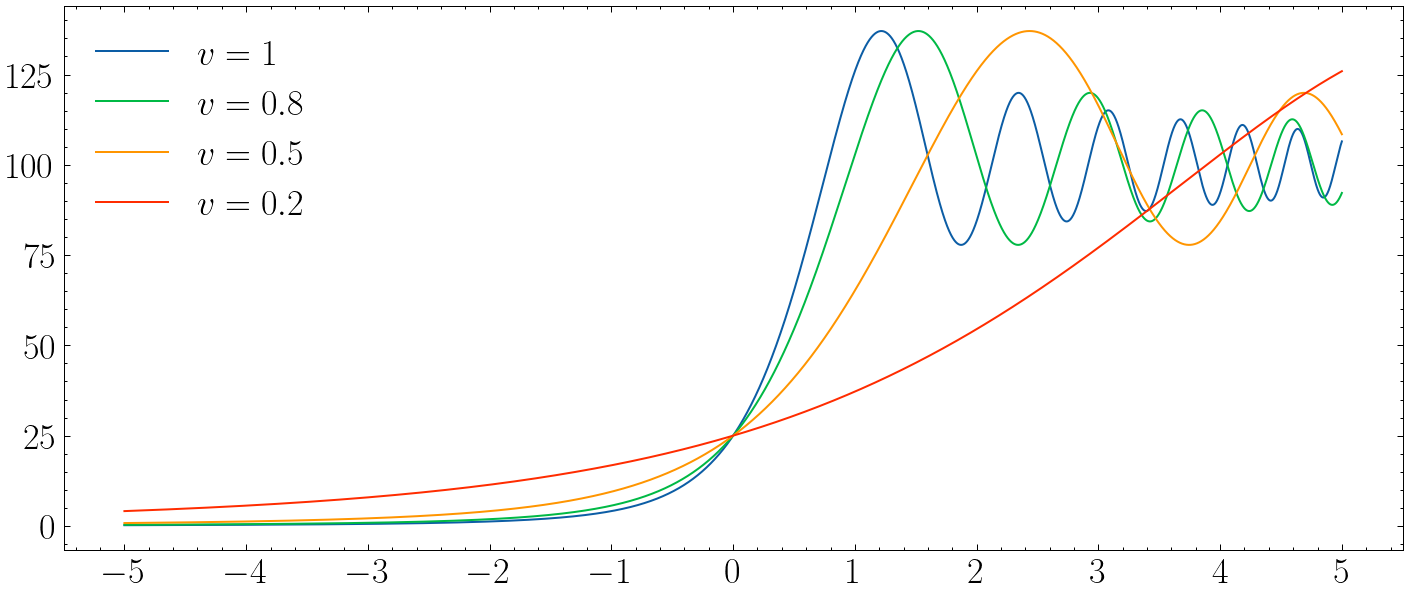

In [4]:
plt.figure(figsize = (12,5), facecolor='w')
nu = np.linspace(-5,5,10000)
# nu=1
plt.plot(nu, diffract(nu, 0, 100, 1))
plt.plot(nu, diffract(nu, 0, 100, 0.8))
plt.plot(nu, diffract(nu, 0, 100, 0.5))
plt.plot(nu, diffract(nu, 0, 100, 0.2))
plt.legend(['$v = 1$','$v = 0.8$', '$v = 0.5$', '$v = 0.2$'])
plt.xticks(np.arange(-5,6));

## Membuat data artifisial yang mengandung *noise*

Asumsikan parameter yang diambil adalah sebagai berikut:
- nilai *noise* adalah $\sigma = 10$
- amplitudo $A = 100$
- kecepatan $v = 1$
- waktu *event* $t_0 = 0$

In [5]:
x_data = np.linspace(-5, 5, 200)
σ_true = 10
A_true = 100
t0_true = 0
v_true = 1

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

y_data = diffract(x_data, t0_true, A_true, v_true)
y_data = rng.normal(y_data, scale=σ_true)

y_data_scaled = y_data / (y_data.std()*2)

A_true_scaled = A_true / (y_data.std()*2)
σ_true_scaled = σ_true / (y_data.std()*2)

Text(0, 0.5, 'Intensity')

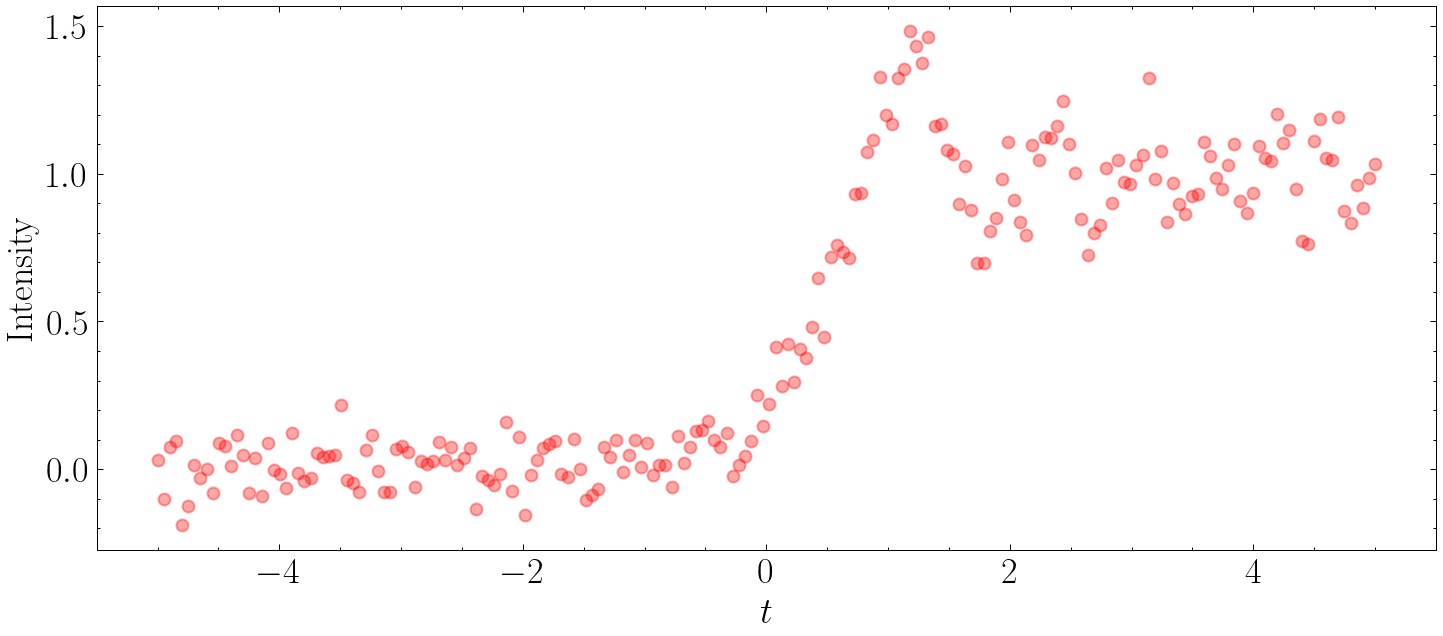

In [6]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data, y_data_scaled, c='r', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')

## *Fitting* dengan metode Bayesian menggunakan MCMC

##### Pembuatan model dan *bayesian inference*

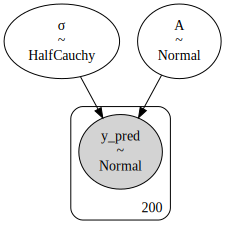

In [7]:
with pm.Model() as model_fresnel:
    amp = pm.Normal('A', mu=1., sigma=0.5)
    σ = pm.HalfCauchy('σ', beta=1.)
    mu = diffract(x_data, t0_true, amp, v_true) # model-nya (expected value)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=σ, observed=y_data_scaled) # likelihood-nya

pm.model_to_graphviz(model_fresnel)

In [8]:
with model_fresnel:
    # trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [9]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.985,0.009,0.967,1.001,0.0,0.0,3559.0,2817.0,1.0
σ,0.088,0.004,0.080,0.096,0.0,0.0,4037.0,2783.0,1.0


Proses di atas digunakan untuk mendapatkan kembali parameter yang sudah ditentukan sebelumnya. Bandingkan hasil yang diperoleh dengan nilai awalnya ($A = 100, \sigma = 10$). <span style="color:red">(catatan: nilai $A$ sudah dinormalisasi ke 1.0)</span>

Text(0, 0.5, '$\\sigma$')

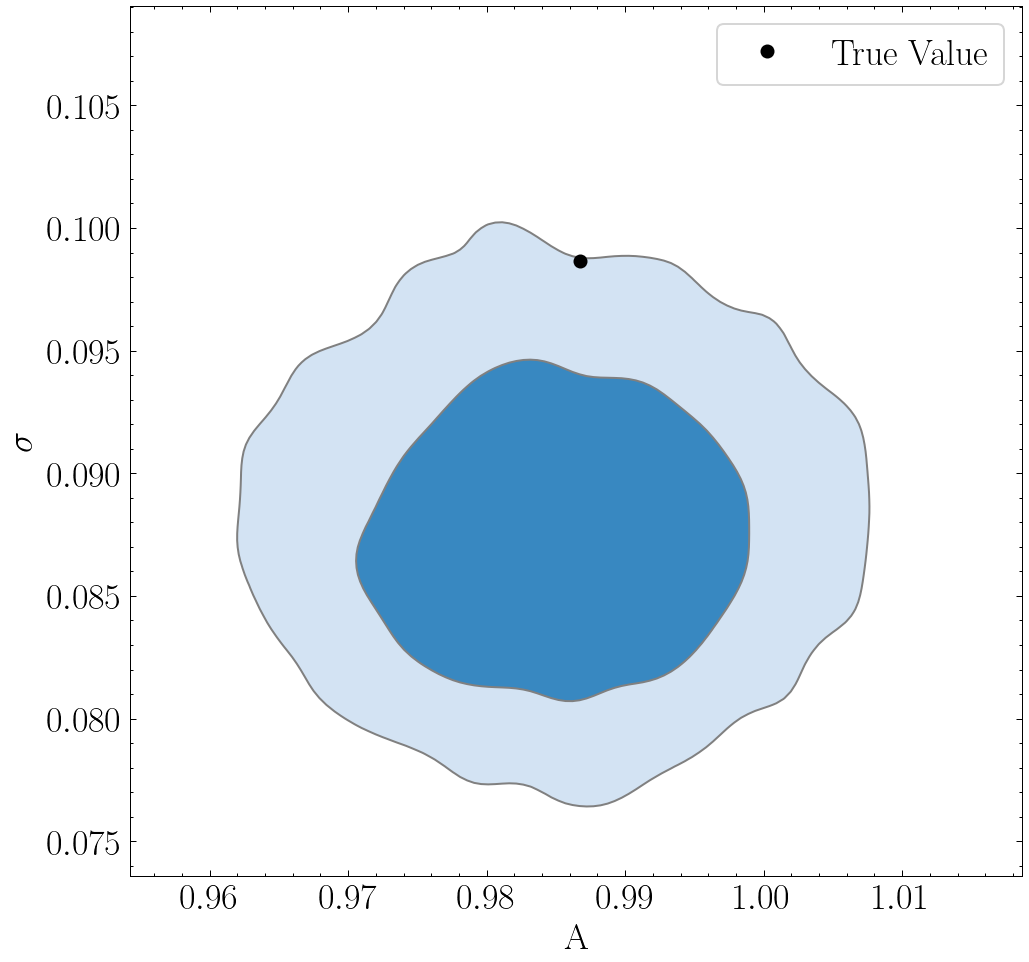

In [10]:
plt.figure(figsize = (8,8))
az.plot_kde(
    idata.posterior.stack(sample=("chain", "draw")).A.values,
    idata.posterior.stack(sample=("chain", "draw")).σ.values,
    contourf_kwargs={"cmap": "Blues"},
    hdi_probs = [0.68, 0.95]
)
plt.plot(A_true_scaled, σ_true_scaled, "ko", label="True Value")
plt.legend(facecolor="white", frameon=True);
plt.xlabel(r"A")
plt.ylabel(r"$\sigma$")

In [11]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [12]:
az.plot_trace(idata, figsize=(12,5))

array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

RuntimeError: latex was not able to process the following string:
b'\\u03c3'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.7) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(../192734b80d07f7f441136abda1f82bd4.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-07-04>
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional information on amsmath, use the `?' option.
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amstext.sty
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsgen.sty))
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsbsy.sty)
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsopn.sty))
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amssymb.sty
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/amsfonts\amsfonts.sty))
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.st
y) (C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\User\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvip
s.def)
No file 192734b80d07f7f441136abda1f82bd4.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! LaTeX Error: Unicode character σ (U+03C3)
               not set up for use with LaTeX.

See the LaTeX manual or LaTeX Companion for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.18 {\rmfamily σ
                  }
No pages of output.
Transcript written on 192734b80d07f7f441136abda1f82bd4.log.
latex: major issue: So far, you have not checked for MiKTeX updates.




<Figure size 864x360 with 4 Axes>

### Posterior Predictive Check

In [ ]:
with model_fresnel:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
idata.posterior_predictive

In [ ]:
az.plot_ppc(idata, num_pp_samples=100);

In [ ]:
idata

## Hitung 2,5% dan 97.5% persentil dan plot bersama dengan data

In [ ]:
idata_pp = idata.posterior_predictive

In [ ]:
test = idata_pp.stack(sample=("chain", "draw"))
crit_l = np.percentile(test['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(test['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(test['y_pred'], axis=1) # Median

In [ ]:
crit_l.shape

In [ ]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))
plt.figure(figsize=(12,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_data_scaled, c='r', marker='o', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

## *Simulated data* untuk proses *disappearance* 

In [ ]:
x_data_2 = np.linspace(-5, 5, 200)
σ_true = 10
A_true = 100
t0_true = 0
v_true = 1

y_data_2 = diffract(-x_data_2, t0_true, A_true, v_true)
y_data_2 = rng.normal(y_data_2, scale=σ_true)

y_data2_scaled = y_data_2 / (y_data_2.std()*2)

In [ ]:
plt.figure(figsize = (12,5), facecolor='w')
plt.scatter(x_data_2, y_data2_scaled, c='r', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')

In [ ]:
with pm.Model() as model_fresnel_2:
    amp = pm.Normal('A', mu=0, sigma=10)
    σ = pm.HalfCauchy('σ', beta=1)
    mu = diffract(-x_data_2, t0_true, amp, v_true) # model-nya (expected value)
    y_pred_2 = pm.Normal('y_pred_2', mu=mu, sigma=σ, observed=y_data2_scaled) # likelihood-nya

In [ ]:
with model_fresnel_2:
    idata = pm.sample()
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [ ]:
az.summary(idata)

In [ ]:
az.plot_kde(
    idata.posterior.stack(sample=("chain", "draw")).A.values,
    idata.posterior.stack(sample=("chain", "draw")).σ.values,
    contourf_kwargs={"cmap": "Blues"},
    hdi_probs = [0.68, 0.95]
)
plt.plot(A_true_scaled, σ_true_scaled, "ko", label="True Value")
plt.legend(facecolor="white", frameon=True);
plt.xlabel(r"A")
plt.ylabel(r"$\sigma$")

In [ ]:
idata

In [ ]:
idata_pp2 = idata.posterior_predictive

In [ ]:
test2 = idata_pp2.stack(sample=("chain", "draw"))
# test['y_pred'].shape
crit_l2 = np.percentile(test2['y_pred_2'], 2.5, axis=1)  # 2.5% persentil 
crit_u2 = np.percentile(test2['y_pred_2'], 97.5, axis=1)  # 97.5% persentil
mean_spp2 = np.mean(test2['y_pred_2'], axis=1) # Median

In [ ]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))
plt.figure(figsize=(12,5))
plt.plot(x_data_2, mean_spp2, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data_2, crit_l2, crit_u2, alpha=0.2, color="#00cc66")
plt.scatter(x_data_2, y_data2_scaled, c='r', marker='o', alpha=0.35)
plt.xlabel(r'$t$')
plt.ylabel('Intensity')
plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'])

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

### Abaikan code di bawah!

In [ ]:
idata

In [ ]:
with model_fresnel_2:
    idata.extend(pm.sample_prior_predictive())

In [ ]:
idata

In [ ]:
prior = idata.prior
prior['σ'].shape

In [ ]:
x = np.linspace(-5, 5, 500)
y = diffract(-x, t0_true, prior['A'], v_true)

In [ ]:
_, ax = plt.subplots()

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)